Maslennikov Nikita, MIPT student [github](https://github.com/masl3noki)

# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [2]:
# If on colab, uncomment the following lines

In [3]:
# You might use this command to install scikit-plot.
# Warning, if you a running locally, don't call pip from within jupyter, call it from terminal in the corresponding
# virtual environment instead

In [4]:
# Google Colab has sklearn v1.2.2, but v1.3+ is needed for better ROC-AUC score plot. Here we are simply upgrading this package:

***Note:*** The task code was not rewritten, only slightly moved for the sake of code style. This is true for every line of task code

In [5]:
#!wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv#
#!pip install scikit-plot
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn

Quite technical remark, but for debugging purposes I will relocate all my functions and imports here

In [3]:
import pandas as pd
import numpy as np
import sklearn as skl

from sklearn.preprocessing import StandardScaler # for data preprocessing
from sklearn.decomposition import PCA # for PCA analysis
from sklearn.model_selection import StratifiedKFold # for better control over cross validation
from sklearn.metrics import accuracy_score,confusion_matrix # for plot_confusionmatrix function
from sklearn import tree # for demonstration purposes: how decision tree classifier is constructed
from sklearn.model_selection import GridSearchCV # for optimal hyperparameters search
from sklearn.metrics import classification_report
from sklearn.base import clone # for model cloning

# key models:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns # for data representation (kinda)
import scikitplot as skplt
from scikitplot.metrics import plot_roc # for roc curve

In [7]:
target_classes = ['bus', 'opel', 'saab', 'van']

def plot_confusionmatrix(y_train_pred, y_train, dom):
  """Create (multiclass) plot of confusion matrix

  Arguments:
    y_train_pred: vector of predicted targets for train dataset of shape (n_features, 1);
    y_train_pred: vector of train targets of shape (n_features, 1);
    dom: string for decoration purposes
  """
  print(f'{dom} Confusion matrix')
  cf = confusion_matrix(y_train_pred,y_train)
  sns.heatmap(cf,
              annot=True,
              yticklabels=target_classes,
              xticklabels=target_classes,
              cmap='Blues',
              fmt='g')
  plt.tight_layout()
  plt.show()

In [8]:
def create_plot_data(clf_gridsearch):
  """Parse GridSearchCV dictionary into data for scoring plot.

  Arguments:
    clf_lr: fitted GridSearchCV class

  Returns:
    tuple object: (X, y_accuracy_score, y_f1_score) of equal (at index 0) shapes
  """
  clf_pd = pd.DataFrame(clf_gridsearch.cv_results_)
  clf_pd_subdata = clf_pd[["param_n_estimators", "mean_test_accuracy", "mean_test_f1_macro"]]
  clf_pd_subdata.sort_values(by=["param_n_estimators"])
  clf_pd_subdata_data = clf_pd_subdata.values.tolist()

  clf_pd_subdata_data_X = []
  clf_pd_subdata_data_Y_acc = []
  clf_pd_subdata_data_Y_f1s = []

  for elem in clf_pd_subdata_data:
    clf_pd_subdata_data_X.append(elem[0])
    clf_pd_subdata_data_Y_acc.append(elem[1])
    clf_pd_subdata_data_Y_f1s.append(elem[2])

  return(clf_pd_subdata_data_X, clf_pd_subdata_data_Y_acc, clf_pd_subdata_data_Y_f1s)

Now, lets read and split the dataset.

In [9]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

(846, 19) (846,)


To get some insights about the dataset, `pandas` might be used. The `train` part is transformed to `pd.DataFrame` below.

In [10]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(data, target, test_size=0.35, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

# First 15 rows of our dataset.
X_train_pd.head(15)

(549, 19) (549,) (297, 19) (297,)


0    1   2    3    4   5   6    7   8   9    10   11   12   13  14  15  \
0   822   95  41   82  170  65   9  145  46  19  145  163  314  140  64   4   
1   486  104  57  103  222  72  12  221  30  25  177  223  718  218  72  11   
2   182   91  42   66  169  66   7  145  44  19  140  169  325  159  67   4   
3   375  109  52   95  189  58   4  227  29  25  158  262  776  217  82   0   
4   528   95  47   73  195  70   7  167  38  20  152  184  430  185  69   9   
5   223   81  44   72  139  60   6  153  44  19  146  180  347  178  81   1   
6   840   93  34   66  140  56   7  130  51  18  120  151  251  114  62   5   
7   593   89  43   77  147  54   8  144  46  19  146  163  308  174  64  13   
8   346  117  52  110  228  65  12  212  31  24  163  228  668  220  66  21   
9   357  109  49  109  193  59  10  207  32  24  156  225  635  213  70  13   
10  482   94  46   79  181  62   8  167  40  20  148  190  418  193  67  12   
11  522   89  36   69  162  63   6  140  48  18  131  164  291  126  66   1   
12  176   84  39   90  180  60   7  177  37  21  131  209  469  145  71   4   
13  680   95  46   76  162  66  11  162  42  20  155  175  381  172  74   8   
14  393   86  47   75  165  68   6  154  43  19  146  176  356  190  74   7   

    16   17   18  
0    8  199  207  
1   12  186  195  
2    0  201  207  
3   19  187  186  
4   19  200  206  
5   15  182  186  
6   29  201  207  
7    5  194  201  
8   25  194  205  
9   31  191  202  
10  15  191  198  
11  38  193  204  
12  38  190  198  
13   4  184  193  
14   3  188  194

Methods `describe` and `info` deliver some useful information.

In [11]:
X_train_pd.describe()

0           1           2           3           4           5   \
count  549.000000  549.000000  549.000000  549.000000  549.000000  549.000000   
mean   425.723133   93.520947   44.675774   81.801457  168.204007   61.644809   
std    242.288797    8.063277    6.154680   15.928751   33.047995    7.110666   
min      0.000000   76.000000   33.000000   42.000000  104.000000   47.000000   
25%    217.000000   87.000000   40.000000   70.000000  140.000000   57.000000   
50%    430.000000   93.000000   44.000000   79.000000  165.000000   61.000000   
75%    636.000000   99.000000   49.000000   98.000000  195.000000   66.000000   
max    845.000000  117.000000   59.000000  110.000000  306.000000  126.000000   

               6           7           8           9           10          11  \
count  549.000000  549.000000  549.000000  549.000000  549.000000  549.000000   
mean     8.457195  167.327869   41.273224   20.468124  147.438980  186.734062   
std      3.945857   32.506680    7.777590    2.526030   14.631309   30.436279   
min      2.000000  114.000000   26.000000   17.000000  118.000000  131.000000   
25%      7.000000  146.000000   34.000000   19.000000  136.000000  167.000000   
50%      8.000000  157.000000   43.000000   20.000000  145.000000  177.000000   
75%     10.000000  196.000000   46.000000   23.000000  159.000000  216.000000   
max     52.000000  265.000000   59.000000   29.000000  186.000000  288.000000   

                12          13          14          15          16  \
count   549.000000  549.000000  549.000000  549.000000  549.000000   
mean    431.540984  173.763206   72.158470    6.522769   12.646630   
std     171.479332   31.793047    7.335198    4.980796    8.833356   
min     191.000000  112.000000   59.000000    0.000000    0.000000   
25%     317.000000  148.000000   67.000000    2.000000    6.000000   
50%     363.000000  173.000000   71.000000    6.000000   11.000000   
75%     576.000000  196.000000   75.000000   10.000000   19.000000   
max    1018.000000  268.000000  127.000000   22.000000   40.000000   

               17          18  
count  549.000000  549.000000  
mean   188.998179  195.854281  
std      6.298389    7.449629  
min    176.000000  181.000000  
25%    184.000000  191.000000  
50%    189.000000  197.000000  
75%    193.000000  201.000000  
max    206.000000  211.000000

In [12]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int64
 1   1       549 non-null    int64
 2   2       549 non-null    int64
 3   3       549 non-null    int64
 4   4       549 non-null    int64
 5   5       549 non-null    int64
 6   6       549 non-null    int64
 7   7       549 non-null    int64
 8   8       549 non-null    int64
 9   9       549 non-null    int64
 10  10      549 non-null    int64
 11  11      549 non-null    int64
 12  12      549 non-null    int64
 13  13      549 non-null    int64
 14  14      549 non-null    int64
 15  15      549 non-null    int64
 16  16      549 non-null    int64
 17  17      549 non-null    int64
 18  18      549 non-null    int64
dtypes: int64(19)
memory usage: 81.6 KB


In [13]:
X_test_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       297 non-null    int64
 1   1       297 non-null    int64
 2   2       297 non-null    int64
 3   3       297 non-null    int64
 4   4       297 non-null    int64
 5   5       297 non-null    int64
 6   6       297 non-null    int64
 7   7       297 non-null    int64
 8   8       297 non-null    int64
 9   9       297 non-null    int64
 10  10      297 non-null    int64
 11  11      297 non-null    int64
 12  12      297 non-null    int64
 13  13      297 non-null    int64
 14  14      297 non-null    int64
 15  15      297 non-null    int64
 16  16      297 non-null    int64
 17  17      297 non-null    int64
 18  18      297 non-null    int64
dtypes: int64(19)
memory usage: 44.2 KB


### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

In [14]:
# step 1: check for data type: we can see object type here: string object
dataset_initial = pd.read_csv('car_data.csv', delimiter=',', header=None)
dataset_initial.dtypes

0      int64
1      int64
2      int64
3      int64
4      int64
5      int64
6      int64
7      int64
8      int64
9      int64
10     int64
11     int64
12     int64
13     int64
14     int64
15     int64
16     int64
17     int64
18     int64
19    object
dtype: object

In [15]:
# step 2: check for null/NaN values:
dataset_initial.isnull().sum().sum()

0

In [16]:
# step 3: check for duplicates
dataset_drop_dup = dataset_initial.drop_duplicates(inplace=False)
print("Dataset shape before .drop_duplicates method:", dataset_initial.shape)
print("Dataset shape after .drop_duplicates method:", dataset_drop_dup.shape)

# we can see that dataset was not changed, neither it contained any NaN values - now thats a great data!

Dataset shape before .drop_duplicates method: (846, 20)
Dataset shape after .drop_duplicates method: (846, 20)


In [17]:
# step 4: check for class imbalance:
print(dataset_initial.iloc[:, 19].value_counts())
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_test).value_counts())

# Everything is great!

bus     218
saab    217
opel    212
van     199
Name: 19, dtype: int64
opel    152
saab    133
bus     132
van     132
dtype: int64
bus     86
saab    84
van     67
opel    60
dtype: int64


Dataset contains no null values, no duplicated values and train/test split of this dataset is balanced (class-wise). Now we are ready for next preprocessing step: `StandartScaler` transform

In [18]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

It is a common practice to scale data, because almost every ML model might behave badly  if the individual features do not more or less look like standard normally distributed data: **Gaussian with zero mean and unit variance**. *Also, see part 1 of ml_pipeline where we discuss how and when we can substract mean from matrix values and/or divide them by standart deviation*

`Standartisation`:
$$x^{scaled}_i = \frac{x_i - \mu}{\sigma}$$

`Mean:`
$$\mu = \frac{1}{n} \sum^n_{i=1} x_i $$

`Standart deviation:`
$$\sigma = \sqrt{\frac{1}{n} \sum^n_{i=1} (x_i-\mu)^2} $$


Standart scaler does its job very well: as we will see later (from sns plot after PCA - unfortunately Lab1_ml_pipeline is structured that way) we can neglect outliner influence on data and not to consider `RobustScaler`, which is well suited for outliners.

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*



---



Although we need to use grid search to find optimal hyperparameters for logistic regression, we are also told to use the following hyperparameters: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`. That means that the only parameter we can change is `penalty`:

In [19]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet']
             }

lr_estimator = LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-3, max_iter=500, l1_ratio=0.5)

grid_search_lr = GridSearchCV(estimator=lr_estimator, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_

GridSearchCV(cv=5,
             estimator=LogisticRegression(l1_ratio=0.5, max_iter=500,
                                          multi_class='multinomial',
                                          solver='saga', tol=0.001),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy', verbose=1)

In [20]:
lr_best = grid_search_lr.best_estimator_
print(classification_report(y_test, lr_best.predict(X_test_scaled)))

              precision    recall  f1-score   support

         bus       0.93      0.98      0.95        86
        opel       0.56      0.82      0.66        60
        saab       0.80      0.49      0.61        84
         van       0.96      0.97      0.96        67

    accuracy                           0.80       297
   macro avg       0.81      0.81      0.80       297
weighted avg       0.83      0.80      0.80       297



In [21]:
print(f'Train score {accuracy_score(lr_best.predict(X_train_scaled),y_train)}')
print(f'Test score {accuracy_score(lr_best.predict(X_test_scaled),y_test)}')
plot_confusionmatrix(lr_best.predict(X_train_scaled),y_train,dom='Train')
plot_confusionmatrix(lr_best.predict(X_test_scaled),y_test,dom='Test')

Train score 0.8214936247723132
Test score 0.8047138047138047
Train Confusion matrix


Test Confusion matrix


As we can see our model is not overfitted, however not that great at distinguishing `opel` and `saab` classes: we get a type I/II errors between them. We can also see that fact at corresponding precision and recall scores.

And this interesting pattern is our main obstacle in this notebook.

By the way, ROC curve gives us better scores, but it is important to understand that ROC AUC compares the relation between True Positive Rate and False Positive Rate, while Accuracy is simply the percentage of correct predictions. It is important to get as many information as possible.

In [22]:
lr_best_roc = plot_roc(y_test, lr_best.predict_proba(X_test_scaled))

Now lets fit same estimator from scratch on non-scaled data and compare scores:

In [23]:
### YOUR CODE HERE
lr_basic = clone(lr_best)
lr_basic.set_params(max_iter=1000)
lr_basic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(l1_ratio=0.5, max_iter=1000, multi_class='multinomial',
                   penalty='l1', solver='saga', tol=0.001)

In [24]:
print(skl.metrics.classification_report(y_test, lr_basic.predict(X_test)))

              precision    recall  f1-score   support

         bus       0.81      0.93      0.86        86
        opel       0.47      0.58      0.52        60
        saab       0.72      0.37      0.49        84
         van       0.80      0.97      0.88        67

    accuracy                           0.71       297
   macro avg       0.70      0.71      0.69       297
weighted avg       0.71      0.71      0.69       297



Train score 0.7577413479052824
Test score 0.7104377104377104
Train Confusion matrix


Test Confusion matrix


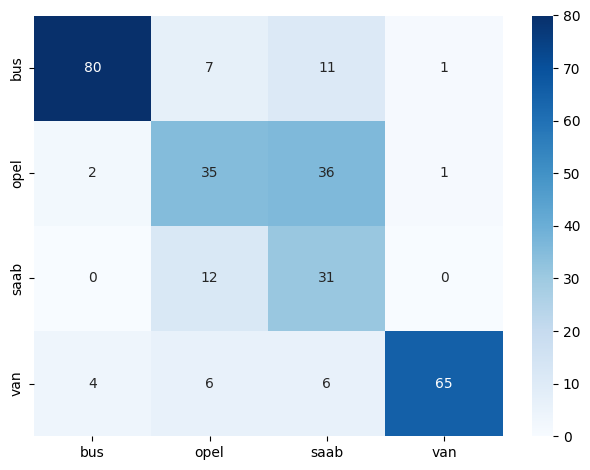

In [25]:
print(f'Train score {accuracy_score(lr_basic.predict(X_train),y_train)}')
print(f'Test score {accuracy_score(lr_basic.predict(X_test),y_test)}')
plot_confusionmatrix(lr_basic.predict(X_train),y_train,dom='Train')
plot_confusionmatrix(lr_basic.predict(X_test),y_test,dom='Test')

We can see that scaling is much needed preprocessing step here, because every score of logistic regression is worse on an unscaled data, rather than on a scaled data.

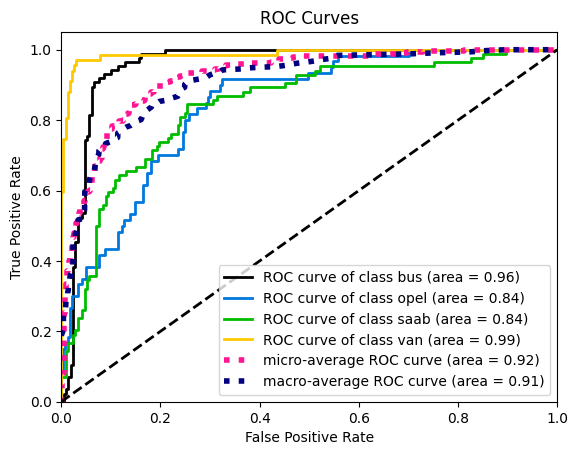

In [26]:
lr_basic_roc = skplt.metrics.plot_roc(y_test, lr_basic.predict_proba(X_test))

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot.



---


We will now use another preprocessing technique of dimension reduction. First we will use PCA on a **scaled** data, find optimal amount of features to keep and modify our dataset.

It is important to scale data first, because overwise we could get wrong features which does not add any crucial info about samples and their patterns.

In [27]:
### YOUR CODE HERE
pca_full = PCA(n_components=19) # For this step we need to consider every unique feature
pca_full.fit(X_train_scaled)

PCA(n_components=19)

<ipython-input-28-b62dadc6cdc9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pca_full.explained_variance_ratio_,ax=axes, palette='cool')


Text(0, 0.5, 'Explained Variance')

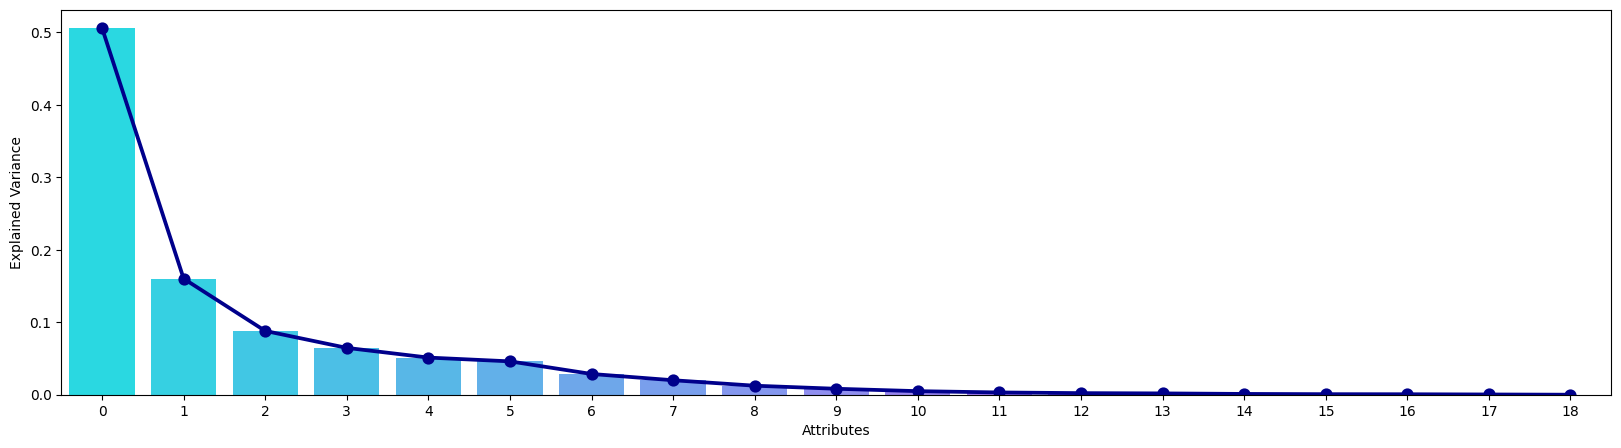

In [28]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(pca_full.explained_variance_ratio_,ax=axes, palette='cool')

plot = sns.pointplot(pca_full.explained_variance_ratio_,ax=axes, color='darkblue')
plot.set_xlabel('Attributes')
plot.set_ylabel('Explained Variance')

What we see here is a plot of feature importances. Dark line represents the "speed" of variance drop. Let's take `10` attributes to work with, however one can choose `8` instead.

In [29]:
pca_atts = PCA(n_components=10, whiten=True)
X_pca = pca_atts.fit_transform(X_train_scaled)

p_plot_data = pd.DataFrame(X_pca)
p_plot_data['class'] = y_train

Plot below shows how every pair of features relate to each other. Diagonal plots represent the marginal distribution of the data. We can see some outliners, but thay are not crucial.

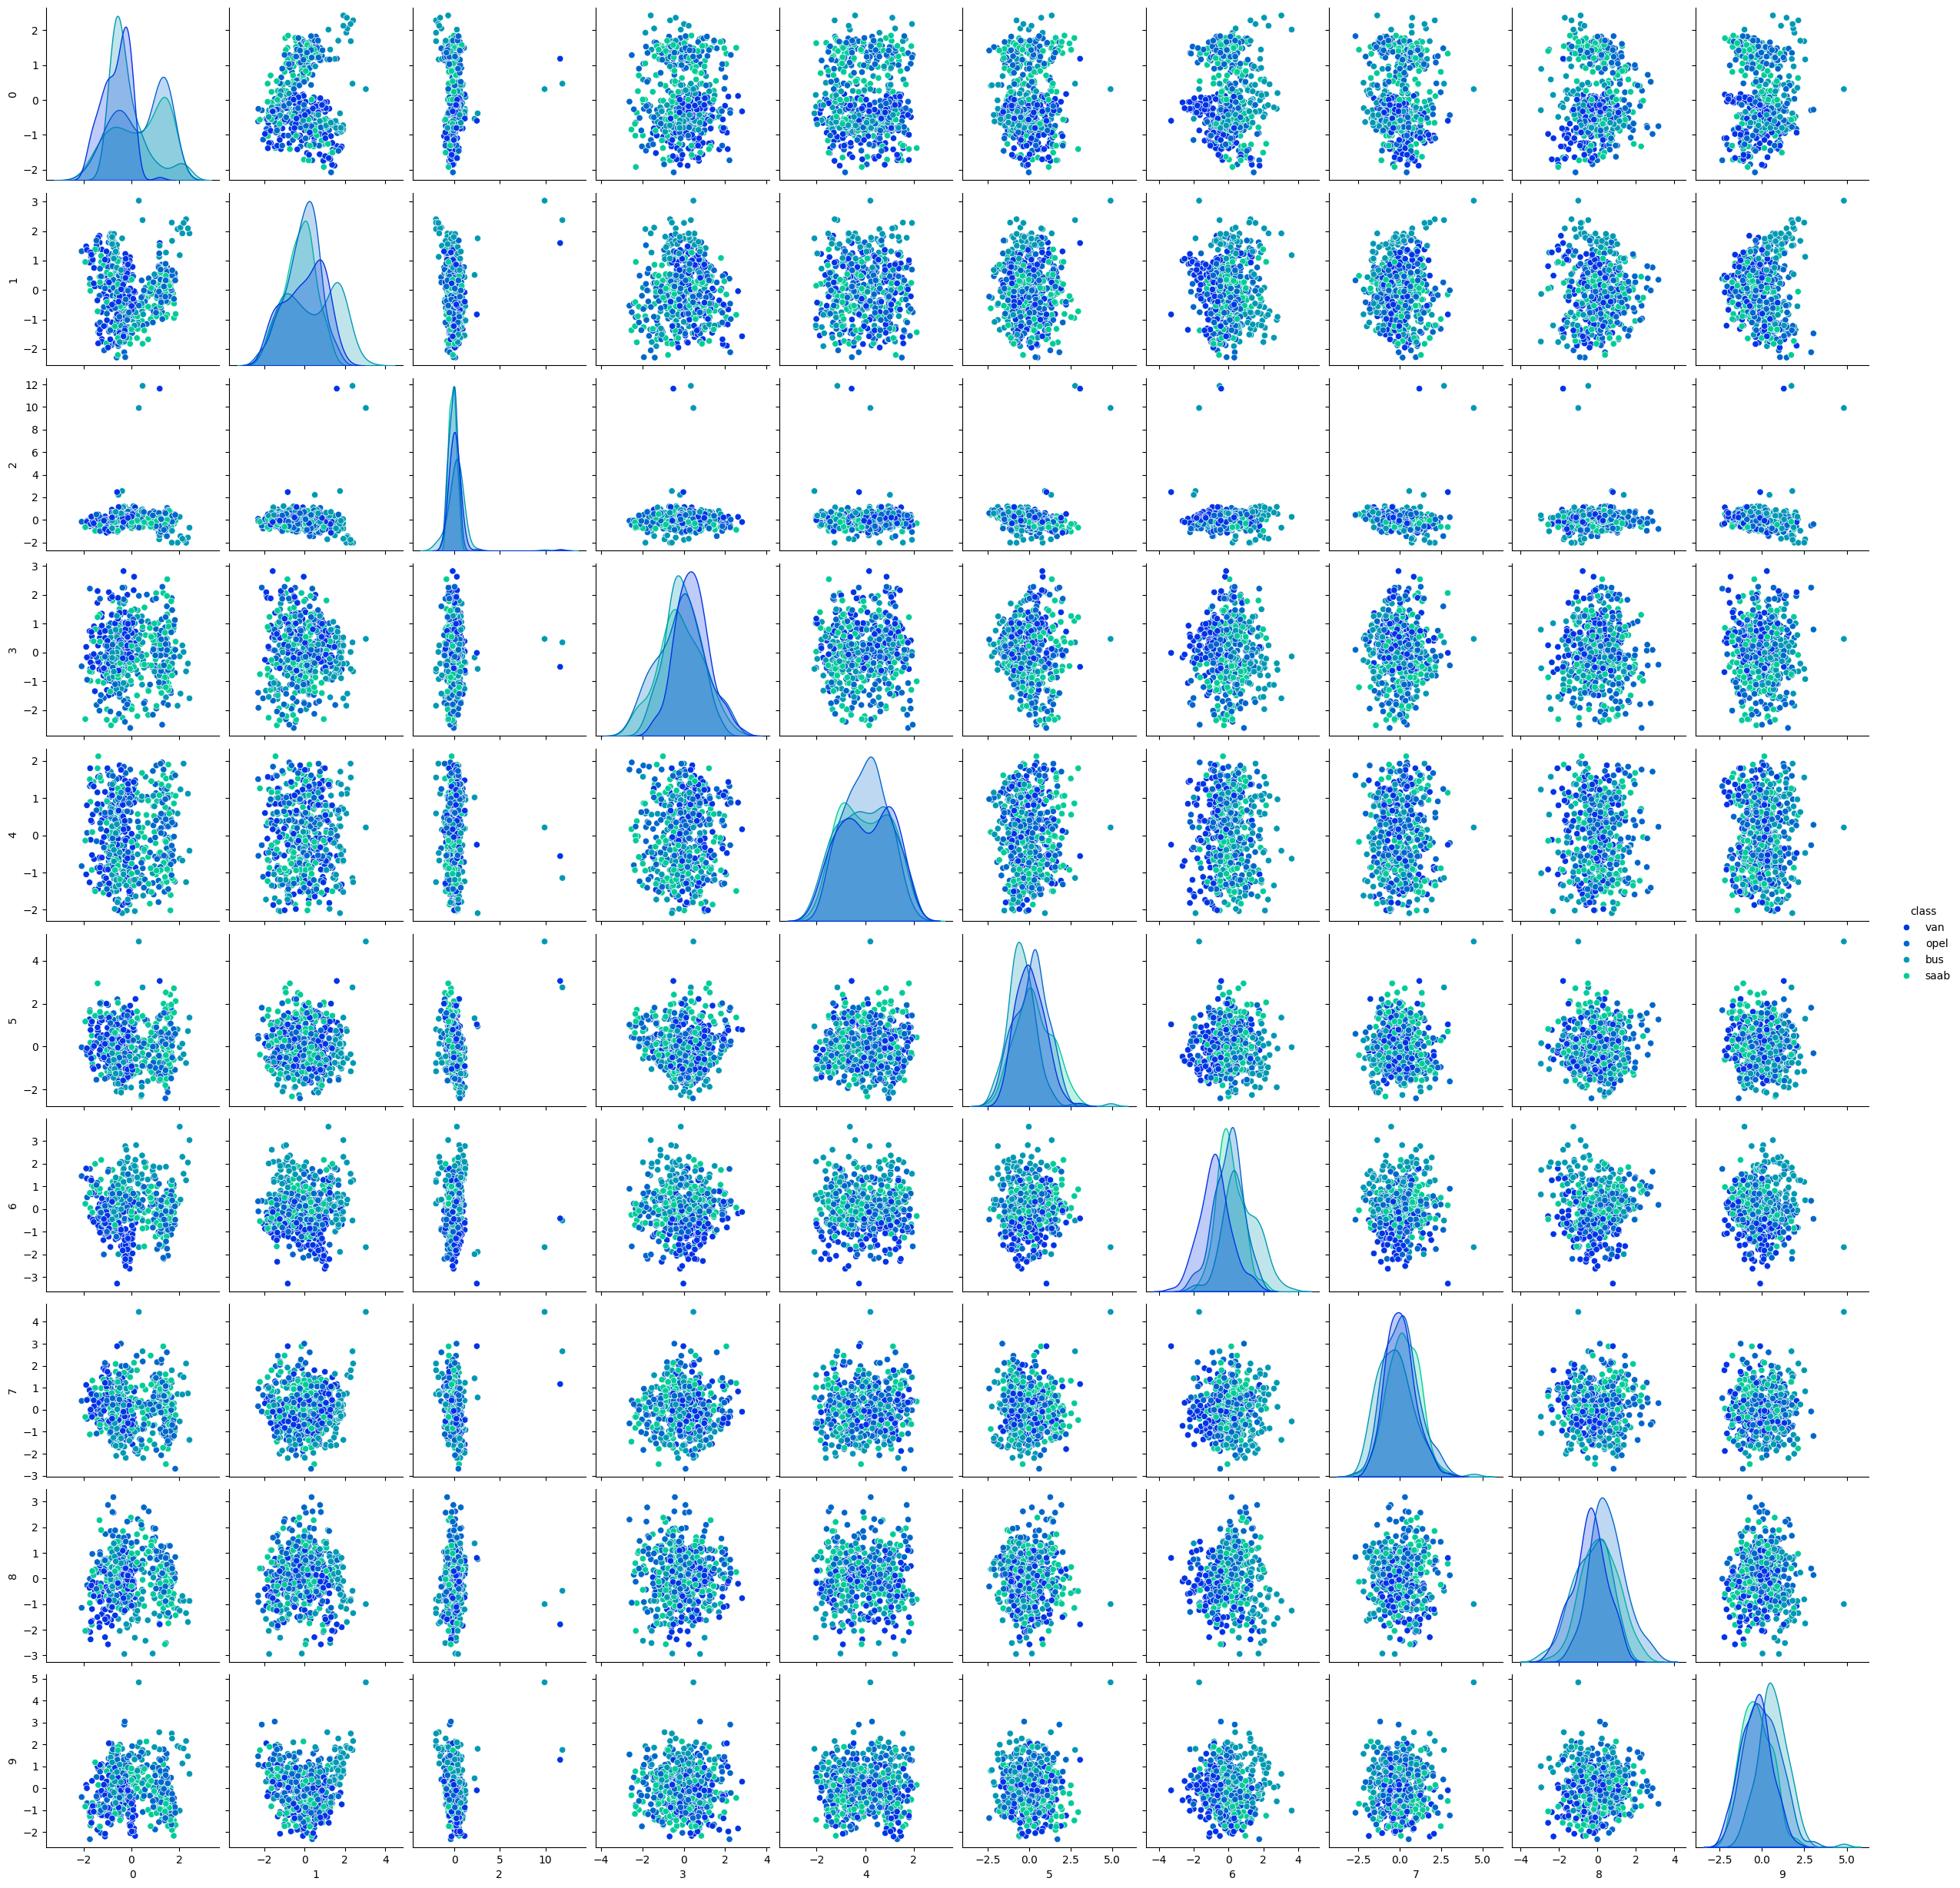

In [30]:
sns.pairplot(p_plot_data, kind='scatter', diag_kind='kde', hue='class', palette='winter')

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*



---


I've explained my choice before `sns.pairplot`: one should always use normalization before PCA.

Now we will once again split our dataset using same `random_state` in order to get better results (overwise we will get different train/test split with possible class imbalance).

In [67]:
##not needed, вариант 2:
#pca_atts = PCA(n_components=12)#, whiten=True)
#X_train_pca = pca_atts.fit_transform(X_train_scaled)
#X_test_pca = pca_atts.transform(X_test_scaled)

In [68]:
### YOUR CODE HERE
# First, lets transform the dataset once again:
scaler_data = skl.preprocessing.StandardScaler().fit(data)
data_scaled = scaler_data.transform(data)
data_pca = pca_atts.fit_transform(data_scaled)

X_train_pca, X_test_pca, y_train, y_test = skl.model_selection.train_test_split(data_pca, target, test_size =.35, random_state=42)

In [69]:
print(X_train_pca.shape)
print(y_train.shape)
print(X_train_pca.shape)
print(y_test.shape)

(549, 12)
(549,)
(549, 12)
(297,)


**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

In [70]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet']
             }

lr_estimator.set_params(max_iter=1000)

grid_search_lr_pca = GridSearchCV(estimator=lr_estimator, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search_lr_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_

GridSearchCV(cv=5,
             estimator=LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                          multi_class='multinomial',
                                          solver='saga', tol=0.001),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy', verbose=1)

In [71]:
lr_pca_best = grid_search_lr_pca.best_estimator_
print(classification_report(y_test, lr_pca_best.predict(X_test_pca)))

              precision    recall  f1-score   support

         bus       0.87      0.91      0.89        86
        opel       0.49      0.73      0.59        60
        saab       0.71      0.43      0.53        84
         van       0.96      0.96      0.96        67

    accuracy                           0.75       297
   macro avg       0.76      0.76      0.74       297
weighted avg       0.77      0.75      0.74       297



Train score 0.7759562841530054
Test score 0.7474747474747475
Train Confusion matrix


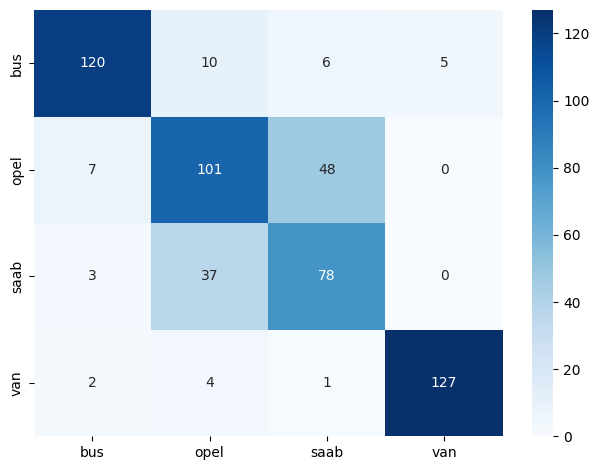

Test Confusion matrix


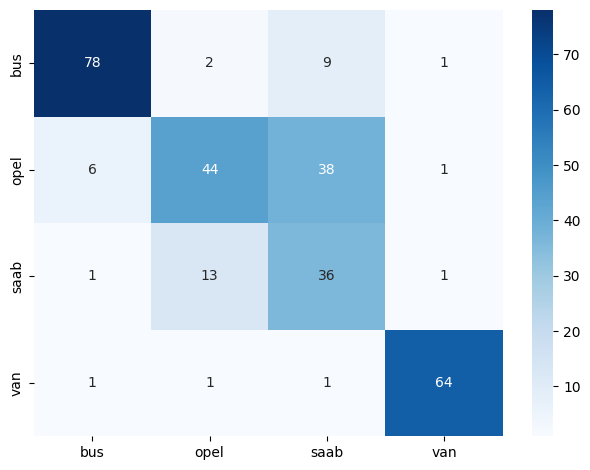

In [72]:
print(f'Train score {accuracy_score(lr_pca_best.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(lr_pca_best.predict(X_test_pca),y_test)}')
plot_confusionmatrix(lr_pca_best.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(lr_pca_best.predict(X_test_pca),y_test,dom='Test')

We've returned to the scores of a Logistic Regression model fitted on an unscaled data.

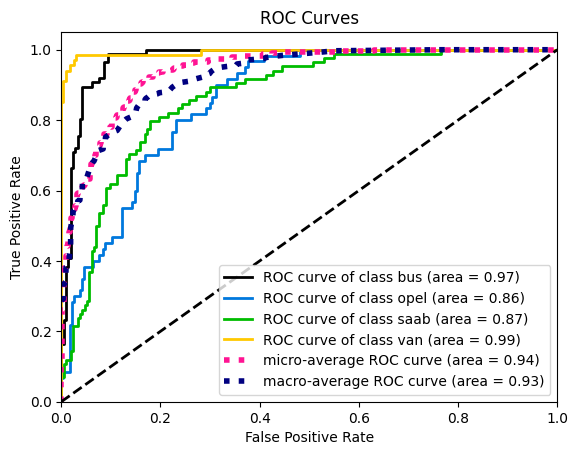

In [73]:
lr_pca_best_roc = plot_roc(y_test, lr_pca_best.predict_proba(X_test_pca))

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

In [92]:
# YOUR CODE HERE
param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

dt_estimator= DecisionTreeClassifier()

grid_search_dt = GridSearchCV(estimator=dt_estimator, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search_dt.fit(X_train_pca, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy', verbose=1)

In [93]:
dt_basic = grid_search_dt.best_estimator_
print(dt_basic)

print(skl.metrics.classification_report(y_test, dt_basic.predict(X_test_pca)))

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='log2')
              precision    recall  f1-score   support

         bus       0.86      0.69      0.76        86
        opel       0.38      0.47      0.42        60
        saab       0.54      0.52      0.53        84
         van       0.67      0.73      0.70        67

    accuracy                           0.61       297
   macro avg       0.61      0.60      0.60       297
weighted avg       0.63      0.61      0.61       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

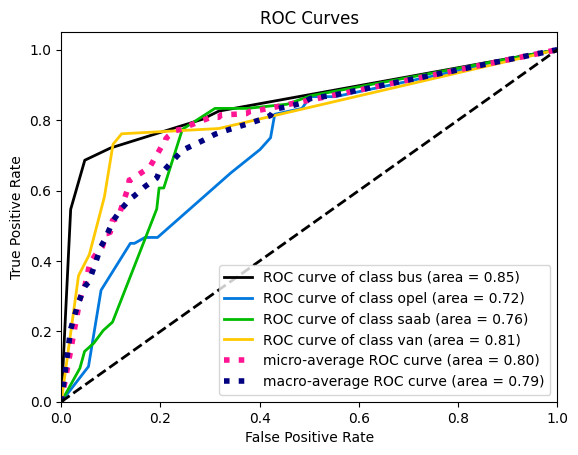

In [95]:
skplt.metrics.plot_roc(y_test, dt_basic.predict_proba(X_test_pca))

In [96]:
print(f'Train score {accuracy_score(dt_basic.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(dt_basic.predict(X_test_pca),y_test)}')
plot_confusionmatrix(dt_basic.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(dt_basic.predict(X_test_pca),y_test,dom='Test')

Train score 0.8087431693989071
Test score 0.6060606060606061
Train Confusion matrix


Test Confusion matrix


It is important to know that Decision Tree by itself is a very unstable model, very prone to overfitting. Here we can experiment a bit by using pruning method and compare the results.

In [98]:
path = dt_basic.cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [108]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = clone(dt_basic)
    clf.set_params(ccp_alpha=ccp_alpha, max_depth=None, random_state=42)
    clf.fit(X_train_pca, y_train)
    clfs.append(clf)

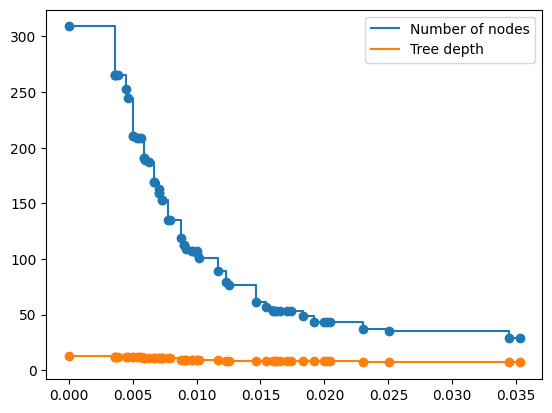

In [109]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='Number of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='Tree depth',drawstyle="steps-post")
plt.legend()
plt.show()

In [110]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train_pca)
    y_test_pred = c.predict(X_test_pca)
    train_acc.append(accuracy_score(c.predict(X_train_pca),y_train))
    test_acc.append(accuracy_score(c.predict(X_test_pca),y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

alpha = 0.018

In [115]:
ccp_alpha_hand_picked = 0.018
dt_better=clone(dt_basic)
dt_better.set_params(ccp_alpha=ccp_alpha_hand_picked, max_depth=None, random_state=42)

dt_better.fit(X_train_pca,y_train)

print(f'Train score {accuracy_score(dt_better.predict(X_train_pca), y_train)}')
print(f'Test score {accuracy_score(dt_better.predict(X_test_pca), y_test)}')
plot_confusionmatrix(dt_better.predict(X_train_pca), y_train,dom='Train')
plot_confusionmatrix(dt_better.predict(X_test_pca), y_test,dom='Test')

Train score 0.7213114754098361
Test score 0.622895622895623
Train Confusion matrix


Test Confusion matrix


In [116]:
print(skl.metrics.classification_report(y_test, dt_better.predict(X_test_pca)))

              precision    recall  f1-score   support

         bus       0.79      0.80      0.80        86
        opel       0.38      0.32      0.35        60
        saab       0.57      0.55      0.56        84
         van       0.64      0.76      0.69        67

    accuracy                           0.62       297
   macro avg       0.60      0.61      0.60       297
weighted avg       0.61      0.62      0.62       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

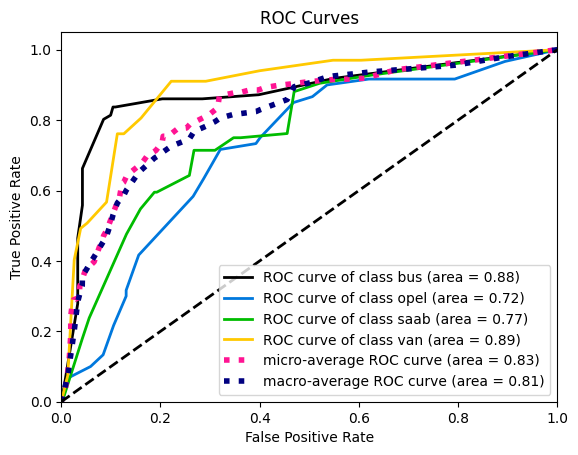

In [117]:
skplt.metrics.plot_roc(y_test, dt_better.predict_proba(X_test_pca))

We got a 1% improvement on accuracy score, but most importantly we got better confusion matrix. Although, it is still far from good.

As we can see, pruning technique helped us to tune Decision Tree classifier and we got a bit better results. But once again, tree classifier by itself is not reliable, but it is a foundation for complex architectures such as bootstrap aggregating (bagging) and random forest. Boosting also counts, but we are not asked to use it in this project.

Here is a plot of pruned tree. Just for the sake of it:

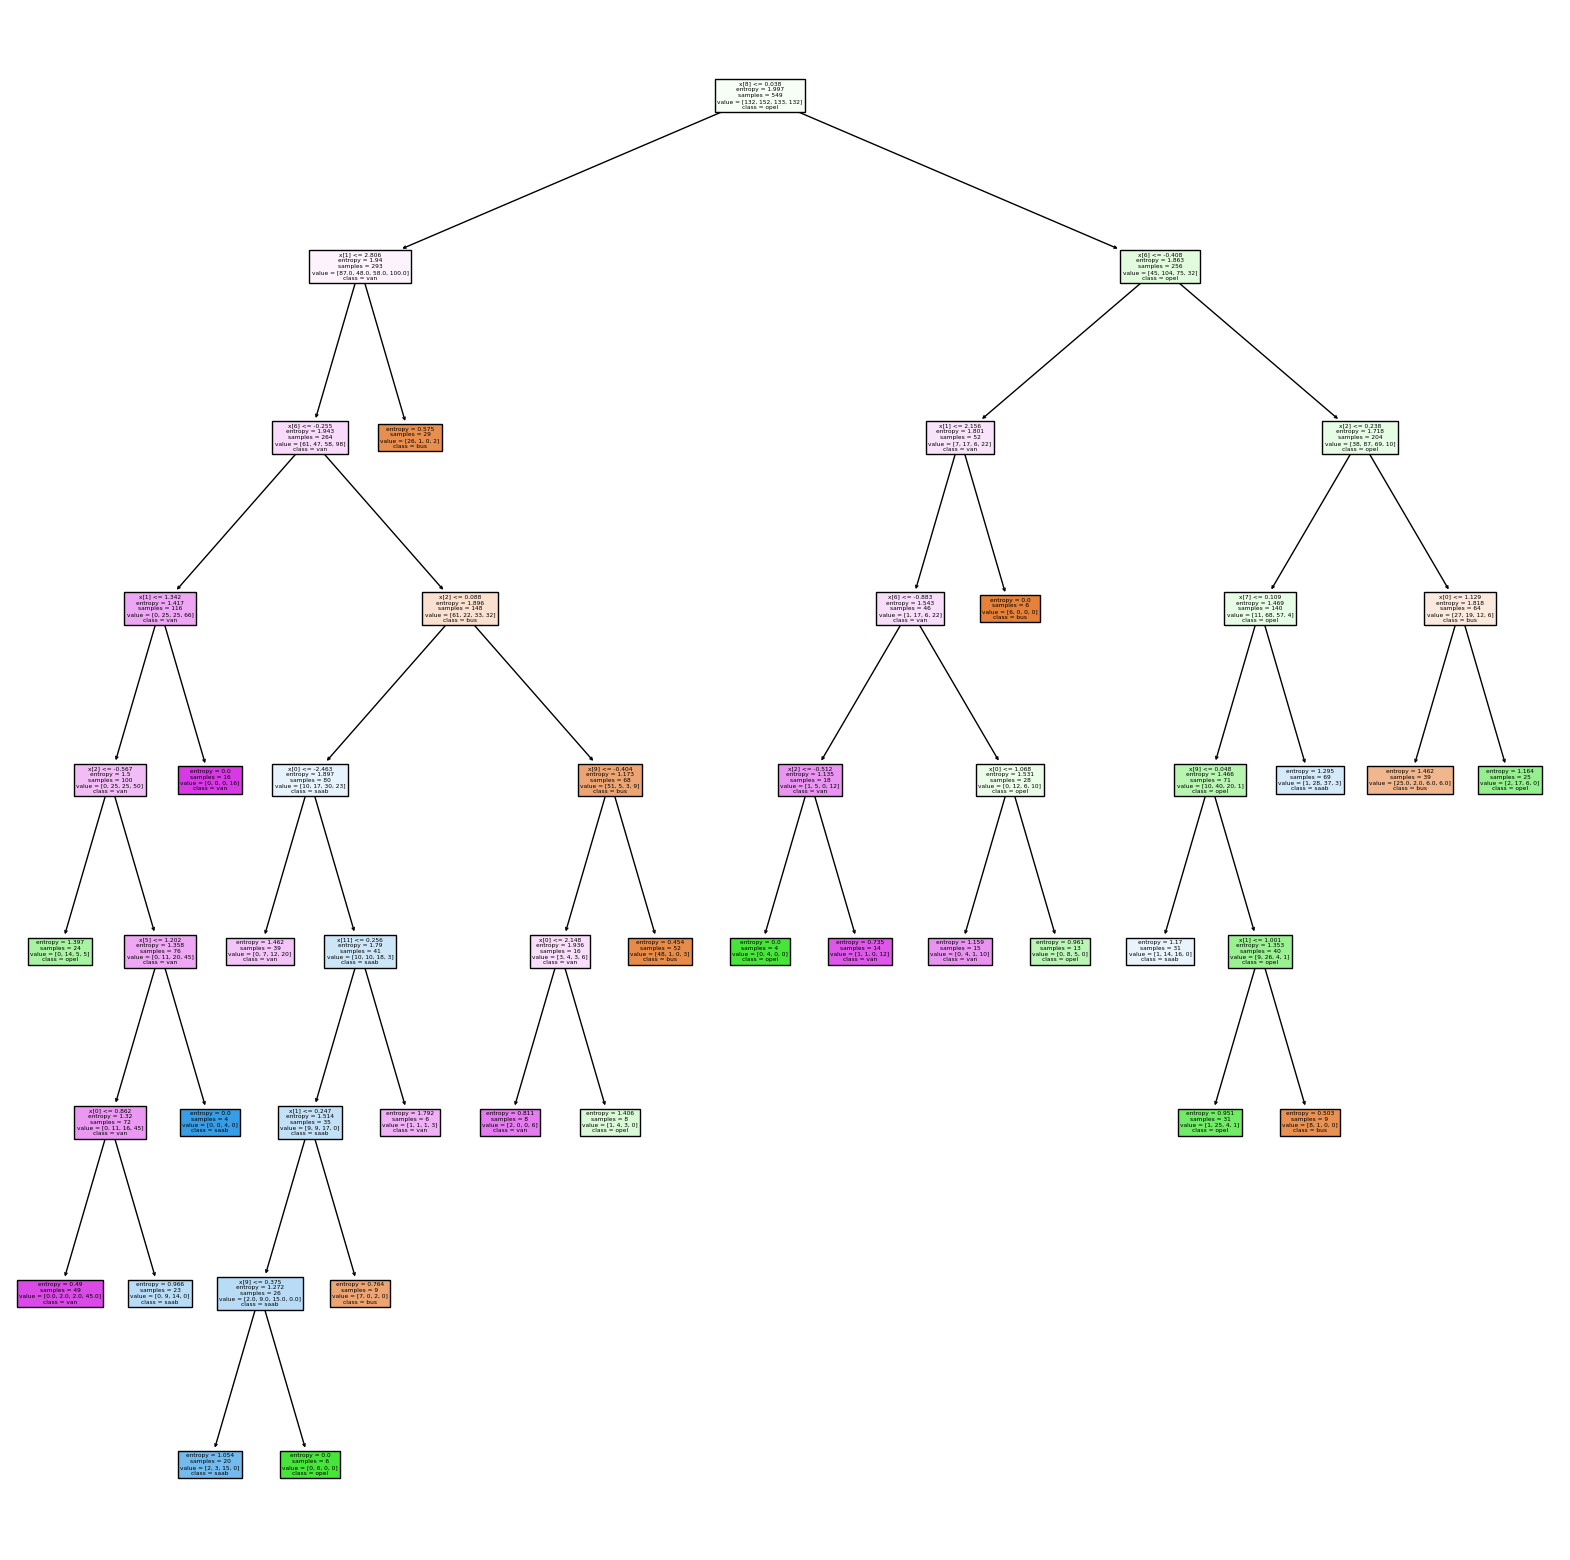

In [118]:
plt.figure(figsize=(20,20))
tree.plot_tree(dt_better,class_names=target_classes,filled=True)

plt.show()

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble?

In [119]:
# YOUR CODE HERE
cross_validation = StratifiedKFold(n_splits=5, shuffle=False)
grid_search_scoring = ['accuracy', 'f1_macro']

I was trying to implement grid search over parameters inside GridSearchCV, a.k.a. '__'  [shenanigans](https://stackoverflow.com/questions/54543612/grid-search-on-parameters-inside-the-parameters-of-a-baggingclassifier), but this is an overkill for linear regression. Moreover, results from this gridsearch (how scoring depends on `n_estimators`) are hard to represent properly, because we will be dealing with slightly different models with each `n_estimators` value. But if I would happen to know the best bagging model on this dataset, I'll use this method.




---



Logistic Regression:

In [171]:
param_grid = {'n_estimators': list(range(2, 100, 5)),
              }

clf_lr = GridSearchCV(BaggingClassifier(LogisticRegression()), param_grid, cv=cross_validation, verbose=1, refit='accuracy', scoring= grid_search_scoring)
clf_lr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=BaggingClassifier(estimator=LogisticRegression()),
             param_grid={'n_estimators': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47,
                                          52, 57, 62, 67, 72, 77, 82, 87, 92,
                                          97]},
             refit='accuracy', scoring=['accuracy', 'f1_macro'], verbose=1)

BaggingClassifier(estimator=LogisticRegression(), n_estimators=17)
              precision    recall  f1-score   support

         bus       0.83      0.93      0.88        86
        opel       0.48      0.70      0.57        60
        saab       0.71      0.42      0.53        84
         van       0.97      0.94      0.95        67

    accuracy                           0.74       297
   macro avg       0.75      0.75      0.73       297
weighted avg       0.76      0.74      0.73       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

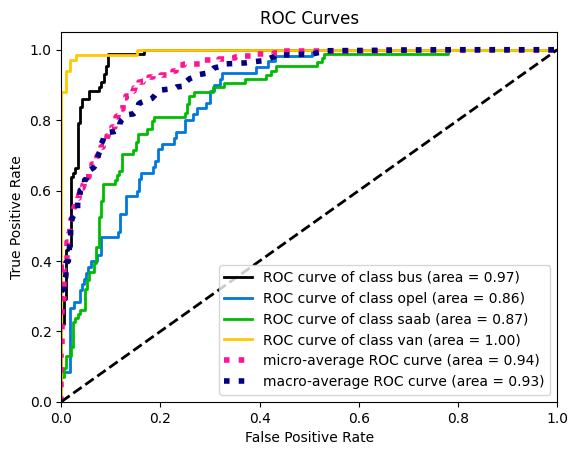

In [172]:
final_model = clf_lr.best_estimator_
print(final_model)

print(skl.metrics.classification_report(y_test, final_model.predict(X_test_pca)))

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test_pca))

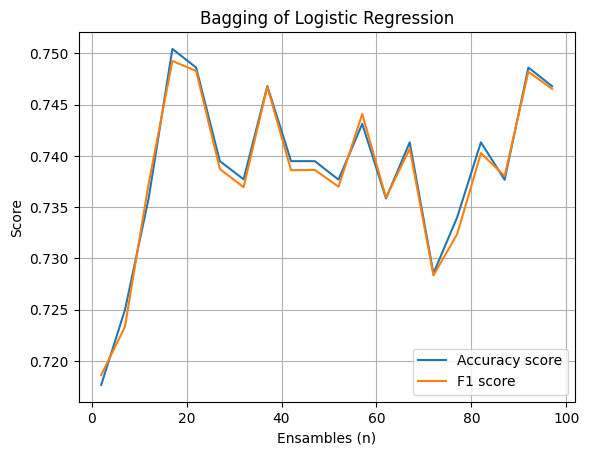

In [174]:
(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(clf_lr)

fig, ax = plt.subplots()
ax.plot(X_plot, Y_plot_acc, label='Accuracy score')
ax.plot(X_plot, Y_plot_f1s, label='F1 score')

ax.set(xlabel='Ensambles (n)', ylabel='Score',
       title='Bagging of Logistic Regression')
ax.grid()
ax.legend()

plt.show()

Logistic Regression should not improve by increasing number of ensambles in theory. Depending on fitting procedure, this plot may say overwise, but it is a coincidence - try rerunning fitting cell again

LogReg bagging score is better than simple LogReg score (on PCA data), but not that much.

Train score 0.7632058287795993
Test score 0.7407407407407407
Train Confusion matrix


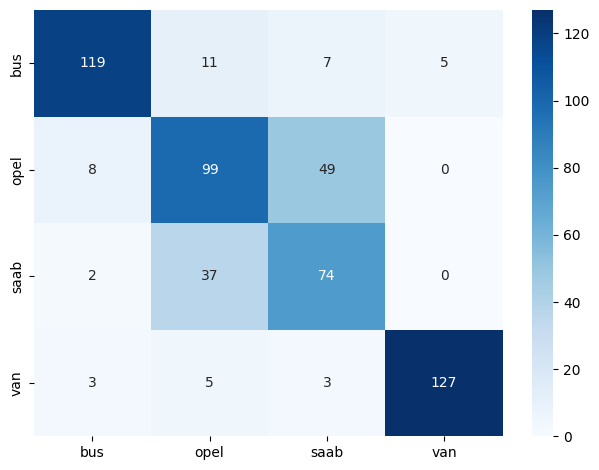

Test Confusion matrix


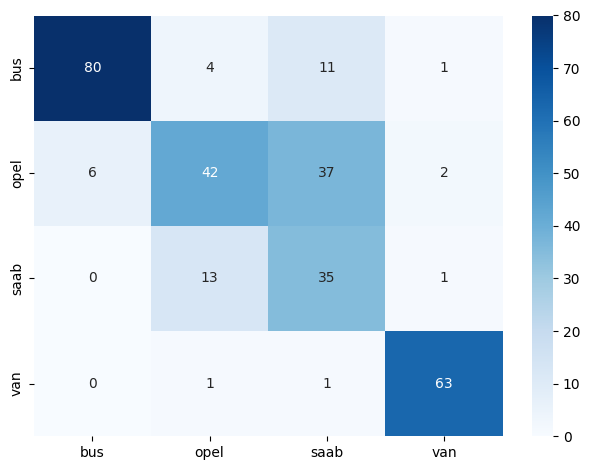

In [175]:
print(f'Train score {accuracy_score(final_model.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(final_model.predict(X_test_pca),y_test)}')
plot_confusionmatrix(final_model.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test_pca),y_test,dom='Test')



---



Decision Tree:

This model will have `bootstrap_features=True` and `oob_score=True`, but because we are told to run through `'n_estimators': [2, 7, ⋯, 92, 97]` we are very likely to get reliable oob score because there are too few estimators in an ensamble.

Also, we will use `f1_macro` score to choose model more fitted to prevent Type I/II errors on `opel` and `saab` classification

In [156]:
param_grid = {'n_estimators': list(range(2, 100, 5)),
              }

dt = DecisionTreeClassifier()

clf_dt = GridSearchCV(BaggingClassifier(dt, bootstrap_features=True, oob_score=True), param_grid=param_grid, cv=cross_validation, verbose=1, refit='f1_macro', scoring= grid_search_scoring)
clf_dt.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:769: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:775: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:769: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:775: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:769: UserWarning: Some inputs do not have OOB scores. This probably means too few e

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=BaggingClassifier(bootstrap_features=True,
                                         estimator=DecisionTreeClassifier(),
                                         oob_score=True),
             param_grid={'n_estimators': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47,
                                          52, 57, 62, 67, 72, 77, 82, 87, 92,
                                          97]},
             refit='f1_macro', scoring=['accuracy', 'f1_macro'], verbose=1)

BaggingClassifier(bootstrap_features=True, estimator=DecisionTreeClassifier(),
                  n_estimators=47, oob_score=True)
{'bootstrap': True, 'bootstrap_features': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 47, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

         bus       0.93      0.94      0.94        86
        opel       0.46      0.62      0.52        60
        saab       0.69

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

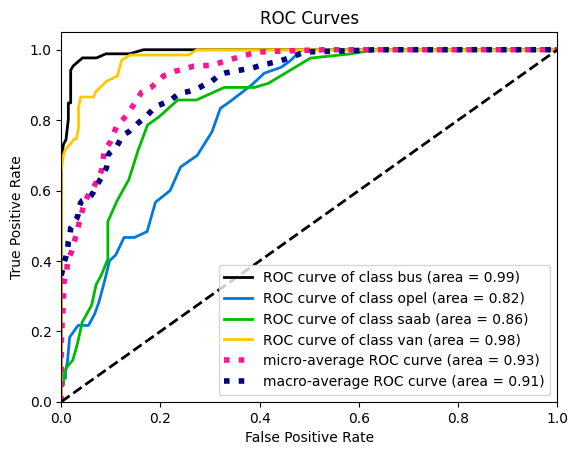

In [208]:
final_model = clf_dt.best_estimator_
print(final_model)
print(final_model.get_params())

print(skl.metrics.classification_report(y_test, final_model.predict(X_test_pca)))

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test_pca))

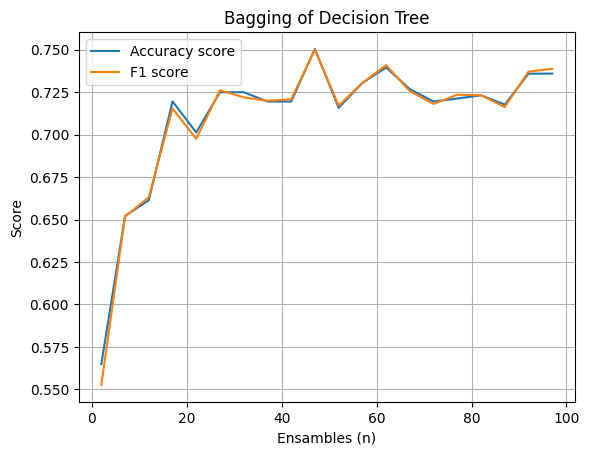

In [177]:
(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(clf_dt)

fig, ax = plt.subplots()
ax.plot(X_plot, Y_plot_acc, label='Accuracy score')
ax.plot(X_plot, Y_plot_f1s, label='F1 score')

ax.set(xlabel='Ensambles (n)', ylabel='Score',
       title='Bagging of Decision Tree')
ax.grid()
ax.legend()

plt.show()

The confusion matrix, of course, talks about retraining, but how serious is that? For the `bus` and `van` classes, the model found clear patterns, but for `opel` and `saab`, the model started to get confused. That could mean that the data for those last two classes is a bit "loose" for finding patterns, and even with pruning, there might be type I and type II errors for those classes.

Train score 1.0
Test score 0.734006734006734
Train Confusion matrix


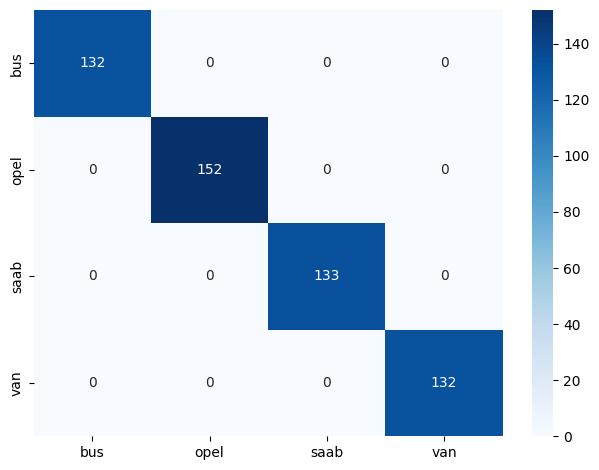

Test Confusion matrix


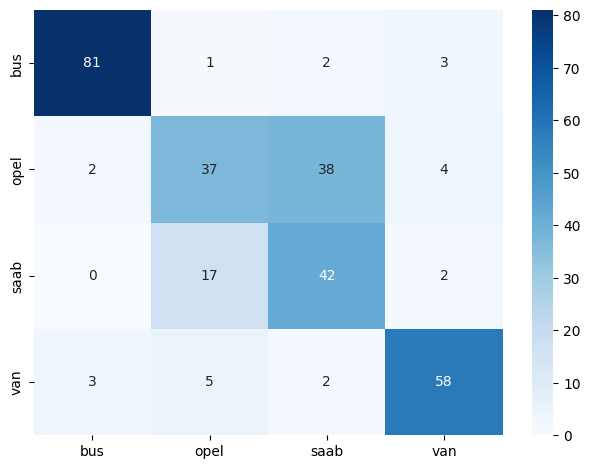

In [178]:
print(f'Train score {accuracy_score(final_model.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(final_model.predict(X_test_pca),y_test)}')
plot_confusionmatrix(final_model.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test_pca),y_test,dom='Test')

Сравним с найденным ранее DT:

              precision    recall  f1-score   support

         bus       0.90      0.95      0.93        86
        opel       0.41      0.63      0.50        60
        saab       0.63      0.32      0.43        84
         van       0.81      0.85      0.83        67

    accuracy                           0.69       297
   macro avg       0.69      0.69      0.67       297
weighted avg       0.70      0.69      0.68       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

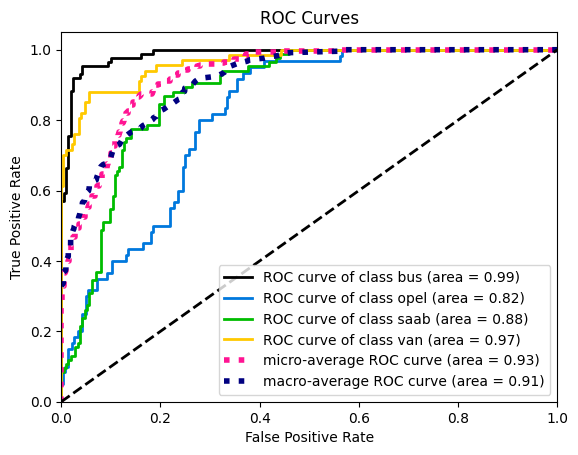

In [209]:
n_estimators_param_dt=final_model.get_params()['n_estimators']
oob_score_param=final_model.get_params()['oob_score']

dt_compare_est=clone(dt_better)
dt_compare=BaggingClassifier(dt_compare_est, n_estimators=72)
dt_compare.set_params(n_estimators=n_estimators_param_dt, oob_score=oob_score_param)

dt_compare.fit(X_train_pca, y_train)

print(skl.metrics.classification_report(y_test, dt_compare.predict(X_test_pca)))

skplt.metrics.plot_roc(y_test, dt_compare.predict_proba(X_test_pca))

As we can see here performance has worsened by using pruned Decision Tree as `base_estimator__` in `BaggingClassificator`. There is a reason behind this behavior. Generally speaking, pruning will hurt performance of bagged trees.

Tress are unstable classifiers; meaning that if you perturb the data a little the tree might significantly change. They are low bias but high variance models. Bagging generally works by "replicating" the model to drive the variance down.

However, we dont gain much if we end up averaging models that are very similar.If the trees are unpruned, they tend to be more different from one another than if they were pruned. This has the effect of "decorrelating" the trees: averaging trees that are not overly similar.

Using unpruned trees will increase the risk of overfiting, but model averaging more than offsets this.

Train score 0.930783242258652
Test score 0.6767676767676768
Train Confusion matrix


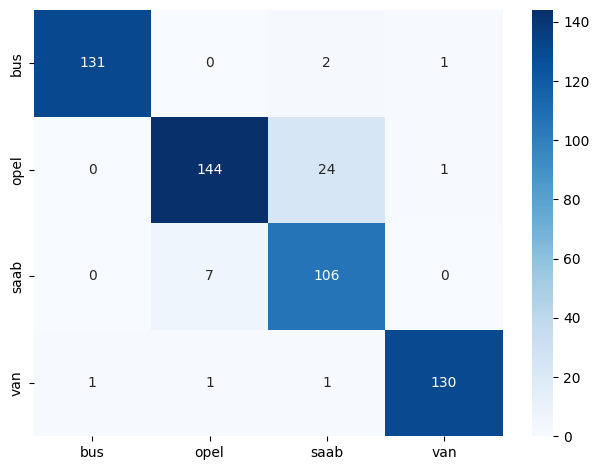

Test Confusion matrix


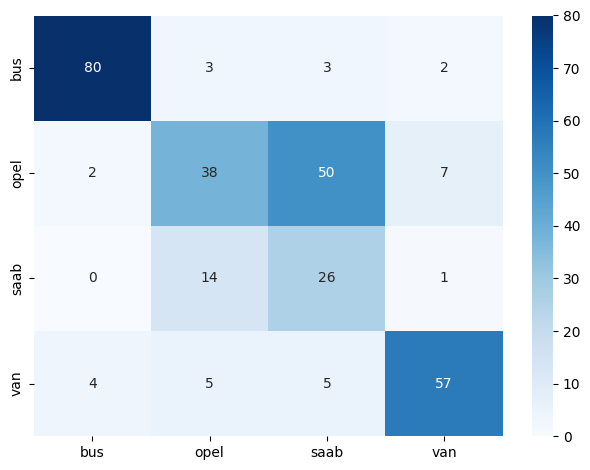

In [180]:
print(f'Train score {accuracy_score(dt_compare.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(dt_compare.predict(X_test_pca),y_test)}')
plot_confusionmatrix(dt_compare.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(dt_compare.predict(X_test_pca),y_test,dom='Test')

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

In [199]:
# YOUR CODE HERE

param_grid = {'n_estimators': list(range(2, 100, 5))}

rf_est = RandomForestClassifier(oob_score=True)

clf_rf = GridSearchCV(rf_est, param_grid=param_grid, cv=cross_validation, verbose=1, refit='f1_macro', scoring= grid_search_scoring)
clf_rf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too fe

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(oob_score=True),
             param_grid={'n_estimators': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47,
                                          52, 57, 62, 67, 72, 77, 82, 87, 92,
                                          97]},
             refit='f1_macro', scoring=['accuracy', 'f1_macro'], verbose=1)

RandomForestClassifier(n_estimators=97, oob_score=True)
              precision    recall  f1-score   support

         bus       0.89      0.95      0.92        86
        opel       0.46      0.65      0.54        60
        saab       0.67      0.43      0.52        84
         van       0.86      0.85      0.86        67

    accuracy                           0.72       297
   macro avg       0.72      0.72      0.71       297
weighted avg       0.73      0.72      0.72       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

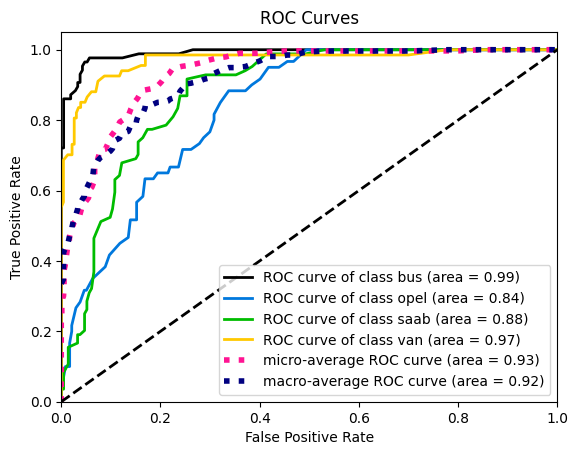

In [200]:
final_model = clf_rf.best_estimator_
print(final_model)

print(skl.metrics.classification_report(y_test, final_model.predict(X_test_pca)))

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test_pca))

Train score 1.0
Test score 0.7205387205387206
Train Confusion matrix


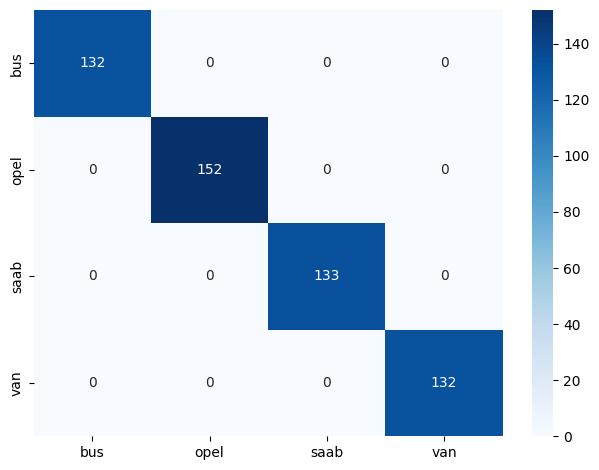

Test Confusion matrix


In [201]:
print(f'Train score {accuracy_score(final_model.predict(X_train_pca),y_train)}')
print(f'Test score {accuracy_score(final_model.predict(X_test_pca),y_test)}')
plot_confusionmatrix(final_model.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test_pca),y_test,dom='Test')

Random Forest overfit. Why is that?

Random Forests are usually built of high-variance, low-bias fully grown decision trees, and their strength comes from the variance reduction that comes from the averaging of these trees. However, if the predictions of the trees are too close to each other then the variance reduction effect is limited, and they might end up overfitting.

This can happen if the dataset is relatively simple, and therefore the fully grown trees perfectly learn its patterns and predict very similarly.



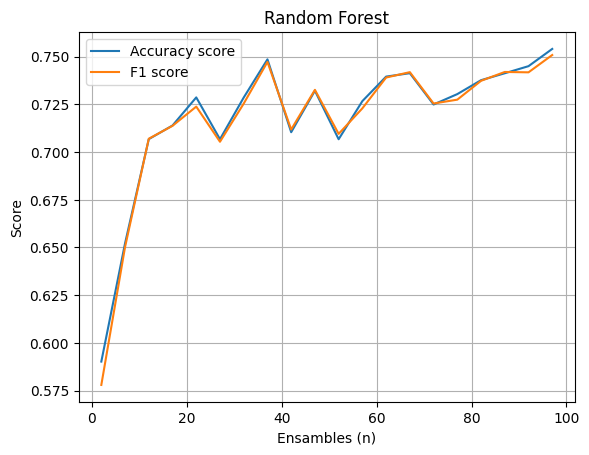

In [202]:
(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(clf_rf)

fig, ax = plt.subplots()
ax.plot(X_plot, Y_plot_acc, label='Accuracy score')
ax.plot(X_plot, Y_plot_f1s, label='F1 score')

ax.set(xlabel='Ensambles (n)', ylabel='Score',
       title='Random Forest')
ax.grid()
ax.legend()

plt.show()

In [211]:
n_estimators_param_2_6 = clf_dt.best_estimator_.get_params()['n_estimators']
n_estimators_param_2_7 = clf_rf.best_estimator_.get_params()['n_estimators']

print("Ensamble size in Decision Tree Bagging (2.6):", n_estimators_param_2_6, "\nEnsamble size in Random Forest (2.7):", n_estimators_param_2_7)

Ensamble size in Decision Tree Bagging (2.6): 47 
Ensamble size in Random Forest (2.7): 97


Unsurprisingly, Random Forest is in dire need for more estimators. Thats because (in general) Random Forest tends to get more percise the bigger the ensamble, unlike models that use bagging techniques

Moreover, we still see `opel` and `saab`misclassifications which means that our data is quite simple and "loose" for those classes.

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it?

In [ ]:
data_pca, target
lr = clone(lr_pca_best)
dt = clone(dt_better)
rf = clone(clf_rf.best_estimator_)

By choosing `random_state != None` we can copy-paste code and set desired scoring without fear of compairing different models.

In [221]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

common_params = {
    "X": data_pca,
    "y": target,
    "train_sizes": np.linspace(0.1, 1.0, 10), # data splitting
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=42),
    "scoring": "accuracy",
    "score_type": "both",
    "n_jobs": -1,
    #"line_kw": {"marker": "o"},
    #"std_display_style": "fill_between",
    "score_name": "Accuracy score",
}

for ax_idx, estimator in enumerate([dt, rf, lr]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])

    if (str({estimator.__class__.__name__}) == "{'DecisionTreeClassifier'}"):
      ax[ax_idx].set_title(f"Learning Curve for pruned DecisionTreeClassifier")
    else:
      ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [223]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

common_params = {
    "X": data_pca,
    "y": target,
    "train_sizes": np.linspace(0.1, 1.0, 10), # data splitting
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=42),
    "scoring": "f1_macro",
    "score_type": "both",
    "n_jobs": -1,
    #"line_kw": {"marker": "o"},
    #"std_display_style": "fill_between",
    "score_name": "F1 score",
}

a = []

for ax_idx, estimator in enumerate([dt, rf, lr]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])

    a.append(str({estimator.__class__.__name__}))

    if (str({estimator.__class__.__name__}) == "{'DecisionTreeClassifier'}"):
      ax[ax_idx].set_title(f"Learning Curve for pruned DecisionTreeClassifier")
    else:
      ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

***Note:*** Models here are with optimal hyperparameters, found in previous chapters of the project.

Compairing this plots, we can see multiple things:

*   Clear overfitting of the Random Forest: I think this dataset contains unaccurate information to clearly distinguish `opel` and `saab` classes. Therefore we get bad result not only by `RandomForestClassifier`, but `BaggingClassifier` and simple models aswell;

*   `Logistic Regression` is slightly worse than `RandomForestClassifier`, but Assuming that all conditions for training models were favorable (which is not true), the best model performance was by **Logistic Regression**. This is debatable, of course;

*   `DecisionTreeClassifier` here was pruned, but because it is a single tree (unstable, prone to overfitting) we can not say much about performance: it is bad and it should be so. Although it is better than unpruned `DecisionTreeClassifier`.



# Overall conclusion: not so great

First: data. It is alright at first glance *(see Data Preprocessing step)*, but as soon as we start training ML models, we start to see the following picture: type I and type II errors in confusion matrixes between `opel` and `saab` classes. I've fitted `RandomForestClassifier` on scaled data and saw same results (presented below).

What more interesting is that I [worked with this dataset before](https://github.com/masl3noki/Y-Y_4.0_ML/blob/main/HW04/Feature%20importances/assignment_importances.ipynb), but in that project we had binary classification: `bus` or `opel` classes. And models' scores were perfect with perfect confusion matrixes (not presented in notebook).

Further research might provide better insights to data distribution, but we might move on part 3 on ML_Pipeline project.




---


As I said before, here is `RandomForestClassifier` fitted on scaled data to prove one point: PCA is not responsible for type I / type II errors, because those errors are presented before applying principle component transformation

In [224]:
# YOUR CODE HERE

param_grid = {'n_estimators': list(range(2, 100, 5))}

rf_est = RandomForestClassifier(oob_score=True)

clf_rf = GridSearchCV(rf_est, param_grid=param_grid, cv=cross_validation, verbose=1, refit='f1_macro', scoring= grid_search_scoring)
clf_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too fe

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(oob_score=True),
             param_grid={'n_estimators': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47,
                                          52, 57, 62, 67, 72, 77, 82, 87, 92,
                                          97]},
             refit='f1_macro', scoring=['accuracy', 'f1_macro'], verbose=1)

RandomForestClassifier(n_estimators=62, oob_score=True)
              precision    recall  f1-score   support

         bus       0.94      0.99      0.97        86
        opel       0.55      0.63      0.59        60
        saab       0.68      0.56      0.61        84
         van       0.91      0.94      0.93        67

    accuracy                           0.78       297
   macro avg       0.77      0.78      0.77       297
weighted avg       0.78      0.78      0.78       297



<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

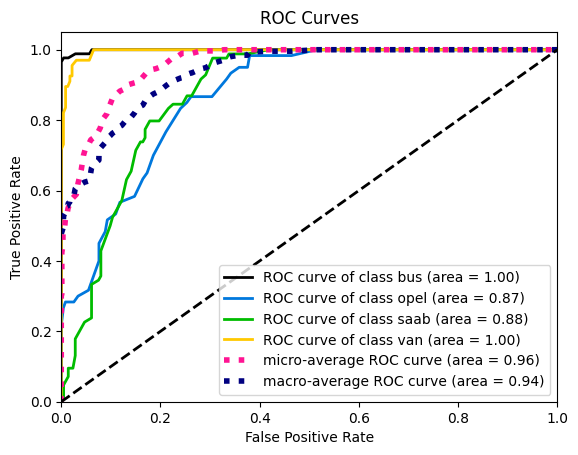

In [226]:
final_model = clf_rf.best_estimator_
print(final_model)

print(skl.metrics.classification_report(y_test, final_model.predict(X_test_scaled)))

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test_scaled))

Train score 1.0
Test score 0.7845117845117845
Train Confusion matrix


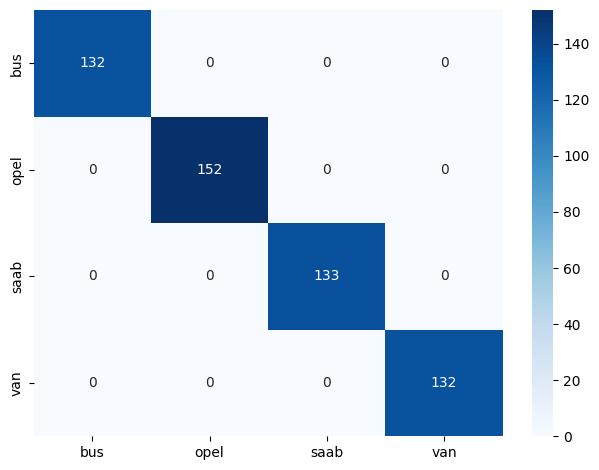

Test Confusion matrix


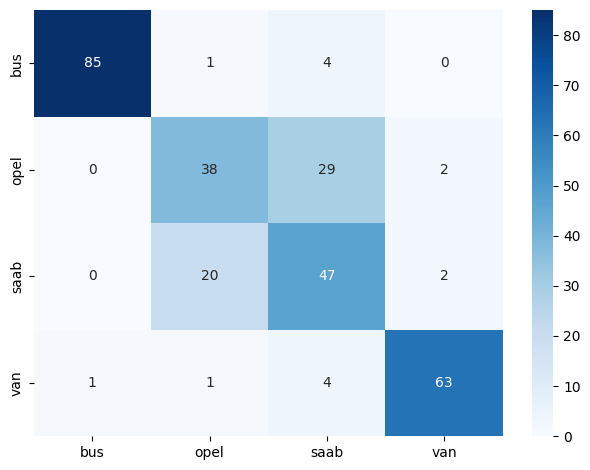

In [227]:
print(f'Train score {accuracy_score(final_model.predict(X_train_scaled),y_train)}')
print(f'Test score {accuracy_score(final_model.predict(X_test_scaled),y_test)}')
plot_confusionmatrix(final_model.predict(X_train_scaled),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test_scaled),y_test,dom='Test')